In [1]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import network_io as nio
from itertools import combinations
import random
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import gc
import random
import pandas as pd
import gzip
import xml.etree.ElementTree as ET

## 1. Check which combinations we have already computed

In [2]:
# path where data is
path = 'pop_1pct_cap_reduction'

result_df_name = 'dataset_1pct_cap_reduction_5k_exp_dist_not_connected'
network_result_name = "networks_5k_normal_dist_not_connected"

result_path = '../../../../data/datasets_simulation_outputs/' + result_df_name + '.pt'

file_path = '../../../../data/pop_1pct_simulations/pop_1pct_cap_reduction/paris_1pct_network.xml.gz'
districts_gdf = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

base_output_links_no_policies = '../../../../data/pop_1pct_simulations/pop_1pct_basecase/output_seed_1/'
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
base_network_no_policies.rename(columns={'link': 'id'}, inplace=True)

base_dir = '../../../../data/pop_1pct_simulations/' + path
subdirs_pattern = os.path.join(base_dir, 'output_networks_*')
subdirs = list(set(glob.glob(subdirs_pattern)))
subdirs.sort()

is_normal_dist = False
is_connected = False
dist_mean = 4
dist_std_dev = 1
number_of_subsets = 5000

## Create subsets 

In [3]:
# List of 20 districts (represented as integers 1 to 20)
districts = list(range(1, 21))

# Function to generate 50,000 unique subsets with sizes following a normal distribution
def generate_unique_not_connected_subsets(districts, mean=4, std_dev=3, target_size=50000, is_normal_dist=True):
    unique_subsets = set()
    
    while len(unique_subsets) < target_size:
        if is_normal_dist:
            # Generate a random subset size from a normal distribution, round to the nearest integer
            subset_size = max(1, int(np.random.normal(mean, std_dev)))
        else:
            # Generate a random subset size from an exponential distribution
            subset_size = max(1, int(np.random.exponential(mean, std_dev)))
        
        # Ensure that subset size does not exceed the number of available districts
        subset_size = min(subset_size, len(districts))
        
        # Randomly sample districts for the subset
        subset = tuple(sorted(random.sample(districts, subset_size)))
        
        # Add the subset to the set of unique subsets
        unique_subsets.add(subset)
    
    return list(unique_subsets)

district_combinations = generate_unique_not_connected_subsets(districts, mean=dist_mean, std_dev=dist_std_dev, target_size=number_of_subsets, is_normal_dist=True) if is_normal_dist else generate_unique_not_connected_subsets(districts, mean=dist_mean, std_dev=dist_std_dev, target_size=number_of_subsets, is_normal_dist=False)

# Check the number of unique subsets
print(f"Number of unique subsets: {len(district_combinations)}")

Number of unique subsets: 5000


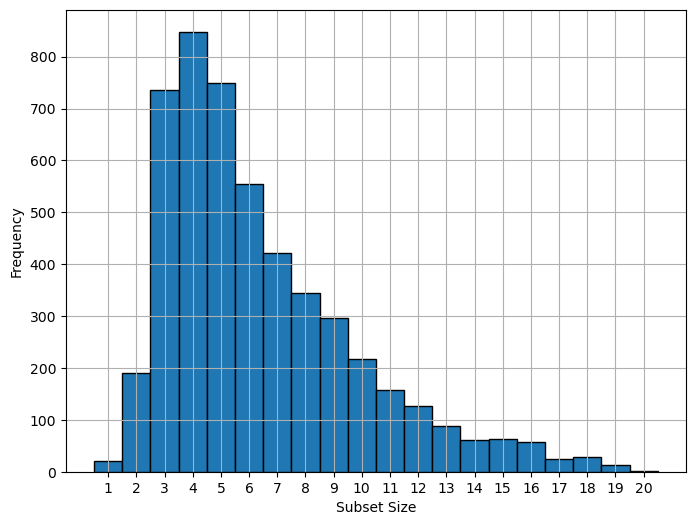

In [4]:
# Extract the sizes of the subsets
subset_sizes = [len(subset) for subset in district_combinations]

# Plot the distribution of subset sizes
plt.figure(figsize=(8, 6))
plt.hist(subset_sizes, bins=range(1, max(subset_sizes)+2), align='left', edgecolor='black')
# plt.title('Distribution of Subset Sizes (Normal Distribution: Mean=4, Std Dev=1)')
plt.xlabel('Subset Size')
plt.ylabel('Frequency')
plt.xticks(range(1, max(subset_sizes)+1))
plt.grid(True)
plt.show()

In [5]:
len(district_combinations)

5000

In [6]:
# Save the random_subset list to a file using pickle
with open(result_path, 'wb') as file:
    pickle.dump(district_combinations, file)

In [7]:
# Parse nodes and edges
nodes_dict = nio.parse_nodes(file_path)
df_edges = nio.parse_edges(file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts_gdf, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

gdf_edges_with_highway = gdf_edges_with_districts.merge(base_network_no_policies[['id', 'osm:way:highway']], on='id', how='left')
gdf_edges_with_highway.head()

higher_order_roads = ['tertiary', 'secondary', 'primary', 'secondary_link', 'primary_link', 'tertiary_link']
filtered_gdf = gdf_edges_with_highway[gdf_edges_with_highway['osm:way:highway'].isin(higher_order_roads)]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry', crs='EPSG:4326')
gdf_edges_with_highway = gpd.GeoDataFrame(gdf_edges_with_highway, geometry='geometry', crs='EPSG:4326')

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [8]:
# Directory to save the files
output_base_dir = '../../../../data/pop_1pct_simulations/' + path +  '/networks/' + network_result_name + '/'

# Number of files per directory
files_per_dir = 1000

# Function to write XML to a compressed .gz file
def write_xml_to_gz(xml_tree, file_path):
    with gzip.open(file_path, 'wb') as f:
        xml_tree.write(f, encoding='utf-8', xml_declaration=True)

# Ensure the base output directory exists
os.makedirs(output_base_dir, exist_ok=True)

# Create and save the networks
for i, combination in enumerate(district_combinations):
    if isinstance(combination, int):
        combination = (combination,)
    df_copy = gdf_edges_with_highway.copy()
    df_copy['policy_introduced'] = df_copy['district'].apply(
        lambda districts: any(d in districts for d in combination)
    ) & df_copy.apply(
        lambda row: 'car' in row['modes'] and row['osm:way:highway'] in higher_order_roads, axis=1
    )
    
    # Modify freespeed and capacity based on the policy_introduced condition
    df_copy.loc[df_copy['policy_introduced'], 'capacity'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2

    # Determine the subdirectory based on the file index
    dir_index = (i // files_per_dir) + 1
    subdir_name = f"networks_{dir_index * files_per_dir}"
    output_dir = os.path.join(output_base_dir, subdir_name)
    
    # Create the subdirectory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    if len(combination) == 1:
        filename = f"network_d_{combination[0]}.xml.gz"
    else:
        filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
    # Convert the DataFrame to XML
    xml_tree = nio.dataframe_to_xml(df_copy, nodes_dict)
    
    # Write the XML to a compressed .gz file
    file_path = os.path.join(output_dir, filename)
    nio.write_xml_to_gz(xml_tree, file_path)

    # Clear the dataframe from memory
    del df_copy
    gc.collect()

# Example: Display the file paths of the saved files
output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
print(output_files)